### （1）将所有分类变量做哑编码；
###  （2）利用totally random treess embedding 方法对原始特征进行特征组合，生成新特征；
###  （3）剔除方差为零的变量；
### （4）将所有特征合并，训练lgb模型

In [49]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomTreesEmbedding
import xgboost as xgb
from sklearn import metrics
import lightgbm as lgb
from copy import deepcopy
from sklearn.externals import joblib
from sklearn.preprocessing import OneHotEncoder
import graphviz
import win32com.client  
import winsound  
%matplotlib inline
plt.rcParams['figure.figsize']=12,4

In [3]:
data_path=r'D:\study\Competition\porto-sequro-safe-driver-prediction\data'
train_df=pd.read_csv(data_path+'\\train.csv',na_values=-1)
test_df=pd.read_csv(data_path+'\\test.csv',na_values=-1)

In [7]:
#所有变量
raw_features=[x for x in train_df.columns if x not in ['id','target']]
#所有二元变量
bin_features=[feat for feat in train_df.columns if 'bin' in feat]
#所有的分类变量
cat_features=[feat for feat in train_df.columns if 'cat' in feat]
#所有calc变量
calc_features=[feat for feat in train_df.columns if 'calc' in feat]

In [8]:
train_df.head(3)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0


### One_Hot_Encoding

In [9]:
def get_dummy_feat(train_df,test_df,cat_features):
    oht_feat=pd.get_dummies(train_df[cat_features].append(test_df[cat_features]),columns=cat_features,dummy_na=True)
    train_df=train_df.join(oht_feat.iloc[0:train_df.shape[0]])
    test_df=test_df.join(oht_feat.iloc[train_df.shape[0]:])
    return train_df,test_df

In [10]:
train_df,test_df=get_dummy_feat(train_df,test_df,cat_features)

### Combined Feature(totally random trees)

In [22]:
rte=RandomTreesEmbedding(n_estimators=30,max_depth=4,max_leaf_nodes=10,sparse_output=False,n_jobs=-1,random_state=9)

In [27]:
def combine_feats(train_df,test_df,combine_raw_feats,combiner,na_fill_values=-1):
    combiner.fit(train_df[raw_features].fillna(na_fill_values))
    train_combine=combiner.transform(train_df[combine_raw_feats].fillna(na_fill_values))
    test_combine=combiner.transform(test_df[combine_raw_feats].fillna(na_fill_values))
    feat_names=['comb_'+str(i) for i in range(1,train_combine.shape[1]+1)]
    train_combine=pd.DataFrame(train_combine,columns=feat_names,index=train_df.index)
    test_combine=pd.DataFrame(test_combine,columns=feat_names,index=test_df.index)
    train_df=train_df.join(train_combine)
    test_df=test_df.join(test_combine)
    return train_df,test_df

In [28]:
train_df,test_df=combine_feats(train_df,test_df,raw_features,rte,na_fill_values=-1)

### 方差为0（或取值唯一）的变量

In [31]:
useless_feats=list(train_df.columns[train_df.var()==0])

In [33]:
use_features=[x for x in train_df.columns if x not in ['id','target']+cat_features+useless_feats]

In [34]:
X=train_df[use_features]
y=train_df['target']

X_predict=test_df[use_features]

In [35]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,stratify=y,random_state=9)

# 1 Base line

In [60]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
 
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum() 

def gini_normalized(preds,dtrain):
    y=dtrain.get_label()
    preds=softmax(preds)
    return 'NormGini',gini(y, preds) / gini(y, y),True

def gini_normalized_ordinary(y,preds):
    return gini(y, preds) / gini(y, y)

def modelfit(alg,X,y,X_test,y_test,cat_features,cvparams,folds=None,useTrainCV=True,cv_folds=5,early_stopping_rounds=30):
    feature_names=list(X.columns)
    if useTrainCV==True:
        dtrain=lgb.Dataset(X, label=y, max_bin=255, reference=None, 
                           weight=None, group=None, silent=False, feature_name=feature_names,
                            categorical_feature=cat_features,params=None, free_raw_data=True)
        cvresult=lgb.cv(cvparams,dtrain,num_boost_round=50000,folds=folds,nfold=cv_folds,stratified=True,
                        metrics='auc',feature_name=feature_names,categorical_feature=cat_features,early_stopping_rounds=early_stopping_rounds,
                        verbose_eval=20,show_stdv =True,seed=9)
        #,feval=gini_normalized
        alg.set_params(n_estimators=len(cvresult['auc-mean']))
        print('Best Iteration:',len(cvresult['auc-mean']))
        
    alg.fit(X,y,eval_metric='auc',feature_name=feature_names,categorical_feature=cat_features)
    
    #Predict training set:
    dtrain_predictions=alg.predict(X)
    dtrain_predprob=alg.predict_proba(X)[:,1]
    
    #pPredict test set:
    dtest_predictions=alg.predict(X_test)
    dtest_predprob=alg.predict_proba(X_test)[:,1]
    
    #Print Mode report:
    print('Model report on trian:')
    #print('Train Accuracy:{0:.4f}'.format(metrics.accuracy_score(y,dtrain_predictions)))
    print('Train AUC:{0:.4f}'.format(metrics.roc_auc_score(y,dtrain_predprob)))
    #print('Train Normalized GINI：{0:.6f}'.format(gini_normalized_ordinary(y,dtrain_predprob)))
    print('Model report on test:')
    #print('Test Accuracy:{0:.4f}'.format(metrics.accuracy_score(y_test,dtest_predictions)))
    print('Test AUC:{0:.4f}'.format(metrics.roc_auc_score(y_test,dtest_predprob)))
    #print('Test Normalized GINI：{0：.6f}'.format(gini_normalized_ordinary(y,dtest_predprob)))
    print('Test classifiction report:')
    print(metrics.classification_report(y_test,dtest_predictions))
    print('Test confusion matrix:')
    plt.figure()
    with sns.axes_style(style='dark'):
        plot_confusion_matrix(metrics.confusion_matrix(y_test,dtest_predictions),classes=['0','1'],
                             title='Confusion Matrix')
    
    feat_imp=pd.Series(alg.feature_importances_,index=X.columns).sort_values(ascending=True)
    #plt.figure()
    #feat_imp.plot(kind='barh',title='Feature Importances',color='green')
    #plt.ylabel('Feature Importance Score')
    lgb.plot_importance(alg,importance_type='split')
    return feat_imp

def turnParams(model,X,y,cat_features,searchParam,modelparams,scoring='roc_auc',cv=5):
    gsc=GridSearchCV(estimator=model.__class__(**modelparams),param_grid=searchParam,scoring=scoring,
                    iid=False,cv=cv)
    gsc.fit(X,y,eval_metric='auc',categorical_feature=cat_features)
    param_name=list(searchParam.keys())[0]
    columns=[p[param_name] for p in gsc.cv_results_['params']]
    cv_scores=pd.DataFrame([gsc.cv_results_['mean_test_score'],
                            gsc.cv_results_['mean_train_score'],
                            gsc.cv_results_['std_test_score'],
                            gsc.cv_results_['std_train_score']],
                            index=['mean_test_score','mean_train_score','std_test_score','std_train_score'],
                            columns=columns).T
    #cv_scores.index.name=param_name
    for param in gsc.best_params_.keys():
        modelparams[param]=gsc.best_params_[param]
    print('Best params:')
    for param in gsc.best_params_.keys():
        print(param,':',gsc.best_params_[param])
    print('Best score:',gsc.best_score_)
    print(cv_scores)
    speak = win32com.client.Dispatch('SAPI.SPVOICE')  
    winsound.Beep(20170, 800)  
    speak.Speak('程序运行完毕!')
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [40]:
params={'boosting_type':'gbdt',
        'num_leaves':50,
        'max_depth':6,
        'learning_rate':0.2,
        'n_estimators':38,
        'max_bin':255,
        'objective':'binary',
        'min_split_gain':0,
        'min_child_weight':0,
        'min_child_samples':1,
        'subsample':1.0,
        'subsample_freq':1,
        'colsample_bytree':1.0,
        'reg_alpha':0,
        'reg_lambda':0,
        'random_state':9,
        'n_jobs':4,
        'is_unbalance':True,
       }

cvparams={'boosting_type':'gbdt',
        'num_leaves':20,
        'max_depth':6,
        'learning_rate':0.2,
        'max_bin':255,
        'objective':'binary',
        'min_gain_to_split':0,
        'min_sum_hessian_in_leaf':0,
        'min_data_in_leaf':1,
        'bagging_fraction':1.0,
        'bagging_freq':1,
        'feature_fraction':1.0,
        'lambda_l1':0,
        'lambda_l2':0,
        'num_threads':4,
        'is_unbalance':True,
       }
#在sklaearn接口中，参数名称发生了变化，需要进行映射
tran_table={ 'min_split_gain':'min_gain_to_split',
             'min_child_weight':'min_sum_hessian_in_leaf',
             'min_child_samples':'min_data_in_leaf',
             'subsample':'bagging_fraction',
             'subsample_freq':'bagging_freq',
             'colsample_bytree':'feature_fraction',
             'reg_alpha':'lambda_l1',
             'reg_lambda':'lambda_l2',
             'n_jobs':'num_threads',
            
             'boosting_type':'boosting_type',
             'num_leaves':'num_leaves',
             'max_depth':'max_depth',
             'learning_rate':'learning_rate',
             'max_bin':'max_bin',
             'objective':'objective',
             'is_unbalance':'is_unbalance'}
def get_lgb_params(sklearn_params,cvparams,tran_table):
    for sklearn_param,lgb_param in tran_table.items():
        cvparams[lgb_param]=sklearn_params[sklearn_param]

In [41]:
lgbc=lgb.LGBMClassifier(**params)

[20]	cv_agg's auc: 0.628345 + 0.00418503
[40]	cv_agg's auc: 0.625136 + 0.00235659
[60]	cv_agg's auc: 0.621914 + 0.00214394
Best Iteration: 13
Model report on trian:
Train AUC:0.6685
Model report on test:
Test AUC:0.6323
Test classifiction report:
             precision    recall  f1-score   support

          0       0.97      0.65      0.78    114704
          1       0.05      0.54      0.10      4339

avg / total       0.94      0.65      0.76    119043

Test confusion matrix:
Confusion matrix, without normalization
[[74644 40060]
 [ 2011  2328]]


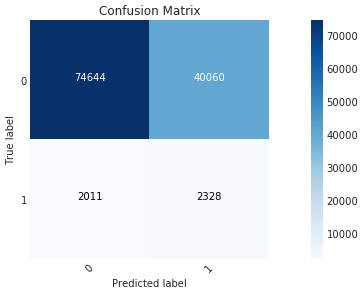

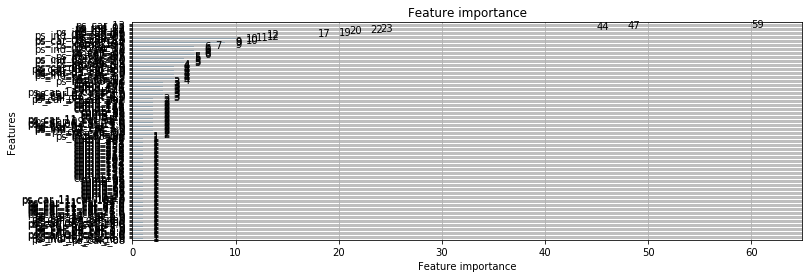

In [42]:
get_lgb_params(lgbc.get_params(),cvparams,tran_table)

feat_imp=modelfit(lgbc,X_train,y_train,X_test,y_test,'auto',cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=50)

In [45]:
params['n_estimators']=13

# 2 Tune params

In [46]:
#不重要的警告信息不予显示
import warnings
warnings.filterwarnings("ignore")

## 2.1 subsample

In [47]:
searchParam={'subsample':[0.1,0.3,0.5,0.7,0.9,1.0]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
subsample : 1.0
Best score: 0.629723203331
     mean_test_score  mean_train_score  std_test_score  std_train_score
0.1         0.592676          0.621134        0.003643         0.000855
0.3         0.615700          0.657228        0.005724         0.000951
0.5         0.621130          0.666217        0.006985         0.002017
0.7         0.625098          0.671901        0.005579         0.001366
0.9         0.627729          0.674632        0.005162         0.001488
1.0         0.629723          0.675214        0.005527         0.001330


In [48]:
searchParam={'subsample':[0.95,0.96,0.97,0.98,0.99,1.0]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
subsample : 0.99
Best score: 0.630477660651
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.95         0.628756          0.674835        0.005005         0.001952
0.96         0.629306          0.674633        0.004773         0.001336
0.97         0.629613          0.675443        0.003655         0.001665
0.98         0.630119          0.676000        0.004557         0.001319
0.99         0.630478          0.675884        0.004471         0.001542
1.00         0.629723          0.675214        0.005527         0.001330


## 2.3 colsample_bytree

In [52]:
searchParam={'colsample_bytree':[0.1,0.3,0.5,0.7,0.9,1.0]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
colsample_bytree : 1.0
Best score: 0.630477660651
     mean_test_score  mean_train_score  std_test_score  std_train_score
0.1         0.620465          0.654775        0.005378         0.001488
0.3         0.629353          0.668536        0.005159         0.001660
0.5         0.628667          0.671158        0.004139         0.001384
0.7         0.628205          0.672902        0.006592         0.000979
0.9         0.629973          0.674517        0.006444         0.001248
1.0         0.630478          0.675884        0.004471         0.001542


In [57]:
searchParam={'colsample_bytree':[0.94,0.95,0.96,0.97,0.98,0.99,1.0]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
colsample_bytree : 1.0
Best score: 0.630477660651
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.94         0.629019          0.675760        0.005462         0.001504
0.95         0.629727          0.675104        0.004640         0.000729
0.96         0.630024          0.675732        0.004576         0.000734
0.97         0.629741          0.675377        0.004977         0.001928
0.98         0.630308          0.675655        0.003893         0.001665
0.99         0.629105          0.675998        0.004794         0.001655
1.00         0.630478          0.675884        0.004471         0.001542


## 2.4 reg_alpha

In [59]:
searchParam={'reg_alpha':[34,35,37,40,45,50]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_alpha : 35
Best score: 0.632301341607
    mean_test_score  mean_train_score  std_test_score  std_train_score
34         0.631638          0.670342        0.005283         0.002022
35         0.632301          0.669847        0.004472         0.002171
37         0.632182          0.669894        0.004128         0.002142
40         0.631227          0.669532        0.004820         0.001925
45         0.631414          0.668631        0.003969         0.001533
50         0.631715          0.668237        0.005519         0.002020


In [61]:
searchParam={'reg_alpha':[34.5,34.7,34.9,35,35.1,35.3,35.5]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_alpha : 34.9
Best score: 0.63236810376
      mean_test_score  mean_train_score  std_test_score  std_train_score
34.5         0.631570          0.670470        0.003887         0.002135
34.7         0.631317          0.670002        0.004823         0.002176
34.9         0.632368          0.669686        0.004401         0.002100
35.0         0.632301          0.669847        0.004472         0.002171
35.1         0.632081          0.669987        0.004149         0.001905
35.3         0.632222          0.669975        0.003611         0.001881
35.5         0.632075          0.669895        0.003405         0.001879


## 2.5 reg_lambda

In [62]:
searchParam={'reg_lambda':[1e-4,5e-4,1e-3,2e-3,3e-3,5e-3,0.01]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_lambda : 0.01
Best score: 0.632368313487
        mean_test_score  mean_train_score  std_test_score  std_train_score
0.0001         0.632368          0.669686        0.004401           0.0021
0.0005         0.632368          0.669686        0.004401           0.0021
0.0010         0.632368          0.669686        0.004401           0.0021
0.0020         0.632368          0.669686        0.004401           0.0021
0.0030         0.632368          0.669686        0.004401           0.0021
0.0050         0.632368          0.669686        0.004401           0.0021
0.0100         0.632368          0.669685        0.004401           0.0021


In [63]:
searchParam={'reg_lambda':[0.009,0.01,0.011,0.05,0.1,1,5]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_lambda : 5
Best score: 0.632814713914
       mean_test_score  mean_train_score  std_test_score  std_train_score
0.009         0.632368          0.669685        0.004401         0.002100
0.010         0.632368          0.669685        0.004401         0.002100
0.011         0.632368          0.669685        0.004401         0.002100
0.050         0.632369          0.669684        0.004401         0.002100
0.100         0.632370          0.669682        0.004401         0.002100
1.000         0.631707          0.669677        0.003786         0.001695
5.000         0.632815          0.670106        0.004375         0.001130


In [64]:
searchParam={'reg_lambda':[4,5,6,8,10,15]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_lambda : 4
Best score: 0.633417963398
    mean_test_score  mean_train_score  std_test_score  std_train_score
4          0.633418          0.670026        0.005780         0.001461
5          0.632815          0.670106        0.004375         0.001130
6          0.633379          0.670056        0.004339         0.001257
8          0.632365          0.669502        0.005442         0.001389
10         0.632487          0.669258        0.004587         0.001784
15         0.632015          0.668896        0.005129         0.001847


In [65]:
searchParam={'reg_lambda':[1.5,2,2.5,3,3.5,4,4.5]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_lambda : 4
Best score: 0.633417963398
     mean_test_score  mean_train_score  std_test_score  std_train_score
1.5         0.632809          0.670051        0.005481         0.001093
2.0         0.632877          0.669828        0.005634         0.001804
2.5         0.632908          0.669982        0.005716         0.001298
3.0         0.632690          0.669957        0.005831         0.001392
3.5         0.632801          0.669672        0.005817         0.001478
4.0         0.633418          0.670026        0.005780         0.001461
4.5         0.632671          0.670176        0.004506         0.001172


## 2.6 min_child_samples

In [66]:
searchParam={'min_child_samples':[1,2,3,4,5,6,7]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
min_child_samples : 4
Best score: 0.633788674578
   mean_test_score  mean_train_score  std_test_score  std_train_score
1         0.633418          0.670026        0.005780         0.001461
2         0.633506          0.669978        0.005703         0.001423
3         0.633581          0.669987        0.005726         0.001422
4         0.633789          0.669960        0.005700         0.001424
5         0.633315          0.669944        0.005974         0.001312
6         0.633315          0.669945        0.005974         0.001312
7         0.633279          0.669954        0.005915         0.001300


## 2.7 min_child_weight

In [67]:
searchParam={'min_child_weight':[0,1e-5,1e-3,0.1,0.5,1.0,3.0,5.0]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
min_child_weight : 0
Best score: 0.633788674578
         mean_test_score  mean_train_score  std_test_score  std_train_score
0.00000         0.633789          0.669960        0.005700         0.001424
0.00001         0.633789          0.669960        0.005700         0.001424
0.00100         0.633789          0.669960        0.005700         0.001424
0.10000         0.633789          0.669960        0.005700         0.001424
0.50000         0.633789          0.669960        0.005700         0.001424
1.00000         0.633565          0.669849        0.005948         0.001303
3.00000         0.633776          0.669958        0.005629         0.001401
5.00000         0.633764          0.669958        0.005621         0.001400


## 2.9 min_split_gain

In [68]:
searchParam={'min_split_gain':[0,0.5,0.9,1,1.1,2,3]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
min_split_gain : 0
Best score: 0.633788674578
     mean_test_score  mean_train_score  std_test_score  std_train_score
0.0         0.633789          0.669960        0.005700         0.001424
0.5         0.632046          0.669680        0.005772         0.001685
0.9         0.632098          0.670028        0.005446         0.002101
1.0         0.632370          0.669848        0.005234         0.001961
1.1         0.632159          0.669805        0.005165         0.001971
2.0         0.631430          0.669340        0.004839         0.002112
3.0         0.632016          0.669354        0.004782         0.001545


## 2.10 num_leaves

In [69]:
searchParam={'num_leaves':[3,5,7,9,11,15,20]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
num_leaves : 20
Best score: 0.633624955583
    mean_test_score  mean_train_score  std_test_score  std_train_score
3          0.617844          0.622475        0.004015         0.001467
5          0.624865          0.630266        0.005095         0.001420
7          0.628424          0.635714        0.005198         0.001434
9          0.629825          0.638636        0.005247         0.001637
11         0.630481          0.641230        0.005560         0.001625
15         0.631743          0.645533        0.006358         0.001581
20         0.633625          0.650339        0.004975         0.001232


In [74]:
searchParam={'num_leaves':[45,50,55,60,70]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
num_leaves : 45
Best score: 0.634314138481
    mean_test_score  mean_train_score  std_test_score  std_train_score
45         0.634314          0.672581        0.004210         0.001167
50         0.633585          0.677290        0.004555         0.001174
55         0.633189          0.680651        0.005958         0.000497
60         0.633988          0.683824        0.003933         0.001476
70         0.633025          0.690767        0.005258         0.000674


In [75]:
searchParam={'num_leaves':[42,43,44,45,46,47,48]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
num_leaves : 43
Best score: 0.635063554422
    mean_test_score  mean_train_score  std_test_score  std_train_score
42         0.634286          0.670756        0.005760         0.001584
43         0.635064          0.671192        0.004812         0.001026
44         0.634135          0.671970        0.005335         0.001044
45         0.634314          0.672581        0.004210         0.001167
46         0.632515          0.672920        0.005396         0.001213
47         0.634282          0.674088        0.005531         0.001218
48         0.634131          0.675116        0.004992         0.001191


## 2.10 max_depth

In [76]:
searchParam={'max_depth':[4,5,6,7,8,9]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
max_depth : 9
Best score: 0.634726181982
   mean_test_score  mean_train_score  std_test_score  std_train_score
4         0.630042          0.644196        0.004323         0.002007
5         0.630419          0.656036        0.004841         0.001883
6         0.632439          0.666359        0.004774         0.001848
7         0.633397          0.669067        0.004440         0.001732
8         0.633954          0.669890        0.005184         0.000547
9         0.634726          0.670847        0.005622         0.001123


In [77]:
searchParam={'max_depth':[9,10,11]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
max_depth : 11
Best score: 0.635202461354
    mean_test_score  mean_train_score  std_test_score  std_train_score
9          0.634726          0.670847        0.005622         0.001123
10         0.635064          0.671192        0.004812         0.001026
11         0.635202          0.671306        0.005949         0.000790


In [79]:
searchParam={'max_depth':[11,12,13,14,15,16,17,18,19,20]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
max_depth : 11
Best score: 0.635202461354
    mean_test_score  mean_train_score  std_test_score  std_train_score
11         0.635202          0.671306        0.005949         0.000790
12         0.634670          0.671258        0.005977         0.000823
13         0.634126          0.671008        0.005354         0.000895
14         0.634222          0.671099        0.005305         0.000910
15         0.634160          0.671111        0.005310         0.000908
16         0.634134          0.671105        0.005335         0.000909
17         0.634134          0.671105        0.005335         0.000909
18         0.634134          0.671105        0.005335         0.000909
19         0.634134          0.671105        0.005335         0.000909
20         0.634134          0.671105        0.005335         0.000909


## 2.11 lower learning_rate

[20]	cv_agg's auc: 0.621139 + 0.00307677
[40]	cv_agg's auc: 0.623833 + 0.00329456
[60]	cv_agg's auc: 0.626209 + 0.00379048
[80]	cv_agg's auc: 0.628595 + 0.00413835
[100]	cv_agg's auc: 0.630333 + 0.00432588
[120]	cv_agg's auc: 0.631667 + 0.00458017
[140]	cv_agg's auc: 0.632734 + 0.00470973
[160]	cv_agg's auc: 0.633844 + 0.00480791
[180]	cv_agg's auc: 0.634788 + 0.0047507
[200]	cv_agg's auc: 0.635628 + 0.0047541
[220]	cv_agg's auc: 0.636371 + 0.00472223
[240]	cv_agg's auc: 0.637023 + 0.00466543
[260]	cv_agg's auc: 0.637604 + 0.00459459
[280]	cv_agg's auc: 0.638 + 0.00463109
[300]	cv_agg's auc: 0.638391 + 0.00465878
[320]	cv_agg's auc: 0.638713 + 0.00473336
[340]	cv_agg's auc: 0.638944 + 0.00474056
[360]	cv_agg's auc: 0.639163 + 0.00480039
[380]	cv_agg's auc: 0.639397 + 0.00481488
[400]	cv_agg's auc: 0.639558 + 0.00480378
[420]	cv_agg's auc: 0.639741 + 0.0047657
[440]	cv_agg's auc: 0.639894 + 0.00470975
[460]	cv_agg's auc: 0.639973 + 0.00463453
[480]	cv_agg's auc: 0.639972 + 0.0045852
[50

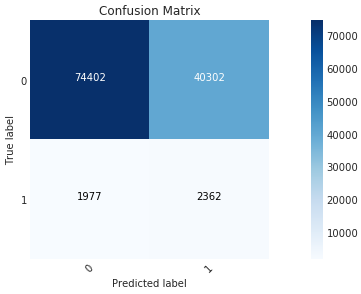

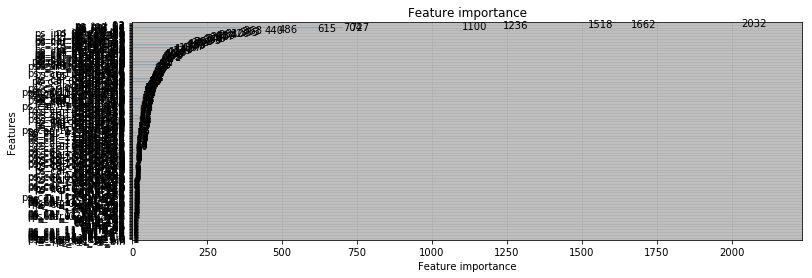

In [80]:
params['learning_rate']=0.01
lgbc=lgb.LGBMClassifier(**params)
get_lgb_params(params,cvparams,tran_table)
feat_imp=modelfit(lgbc,X_train,y_train,X_test,y_test,'auto',cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=50)

In [92]:
params['n_estimators']=545

# 3 Final model

In [93]:
params

{'boosting_type': 'gbdt',
 'colsample_bytree': 1.0,
 'is_unbalance': True,
 'learning_rate': 0.01,
 'max_bin': 255,
 'max_depth': 11,
 'min_child_samples': 4,
 'min_child_weight': 0,
 'min_split_gain': 0,
 'n_estimators': 545,
 'n_jobs': 4,
 'num_leaves': 43,
 'objective': 'binary',
 'random_state': 9,
 'reg_alpha': 34.9,
 'reg_lambda': 4,
 'subsample': 0.99,
 'subsample_freq': 1}

In [94]:
lgbc_opt=lgb.LGBMClassifier(**params)

### cv

In [95]:
searchParam={'n_estimators':[545]}
turnParams(lgbc_opt,X,y,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
n_estimators : 545
Best score: 0.640854373079
     mean_test_score  mean_train_score  std_test_score  std_train_score
545         0.640854          0.695048        0.002836         0.000717


In [96]:
lgbc_opt.fit(X,y,feature_name=list(X.columns),categorical_feature='auto')

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, is_unbalance=True,
        learning_rate=0.01, max_bin=255, max_depth=11, min_child_samples=4,
        min_child_weight=0, min_split_gain=0, n_estimators=545, n_jobs=4,
        num_leaves=43, objective='binary', random_state=9, reg_alpha=34.9,
        reg_lambda=4, silent=True, subsample=0.99, subsample_for_bin=50000,
        subsample_freq=1)

In [97]:
joblib.dump(lgbc_opt,r'D:\study\Competition\kaggle-PSSDP-20171014\20171106_17LightGBM.pkl')

['D:\\study\\Competition\\kaggle-PSSDP-20171014\\20171106_17LightGBM.pkl']

In [98]:
pred_prob=lgbc_opt.predict_proba(X_predict)[:,1]

In [99]:
predict_result=pd.DataFrame({'id':test_df['id'].astype(int),'target':pd.Series(pred_prob,index=test_df['id'].index)})

In [102]:
predict_result.head()

,id,target
0,0,0.404214
1,1,0.404432
2,2,0.429248
3,3,0.301466
4,4,0.495673


In [101]:
predict_result.to_csv(r'D:\study\Competition\kaggle-PSSDP-20171014\20171106_17lgbm.csv',index=False)

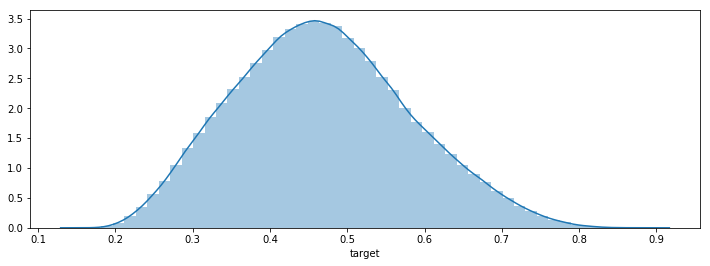

In [172]:
sns.distplot(predict_result['target'])

In [173]:
predict_result['target'].describe()

count    892816.000000
mean          0.467750
std           0.112784
min           0.152381
25%           0.386147
50%           0.463037
75%           0.543116
max           0.893551
Name: target, dtype: float64